In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.output {font-size:10pt;}
div.input {font-family:Consolas; font-size:10pt; font-weight:bold;}
div.prompt {min-width:70px;}
</style>
"""))

**<font size='6' color='darkred'>ch05. RNN을 이용한 작곡</font>**

# 코딩 준비 

- 참조 document :  https://web.mit.edu/music21/doc/index.html
- 참조 예제 : https://bit.ly/2HQ9Q4J
- 참조 데이터 : https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
- 악보 처리용 프로그램 추가 :https://musescore.org  (MuseScore3인스톨)
- 악보를 보기 위한 setting :
    - us=music21.environment.UserSettings()
    - us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"

- pip install music21

In [2]:
import numpy as np
import music21
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os 

# 데이터 준비하기

## 시퀀스 데이터 정의 

In [3]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

print("length of seq: ",len(seq))

length of seq:  54


In [4]:
print(seq)

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [5]:
note_seq = " ".join(seq)
print(note_seq)

m = music21.converter.parse("2/4" + note_seq, 
                           format = "tinyNotation")
m.show("midi")

g8 e8 e4 f8 d8 d4 c8 d8 e8 f8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4


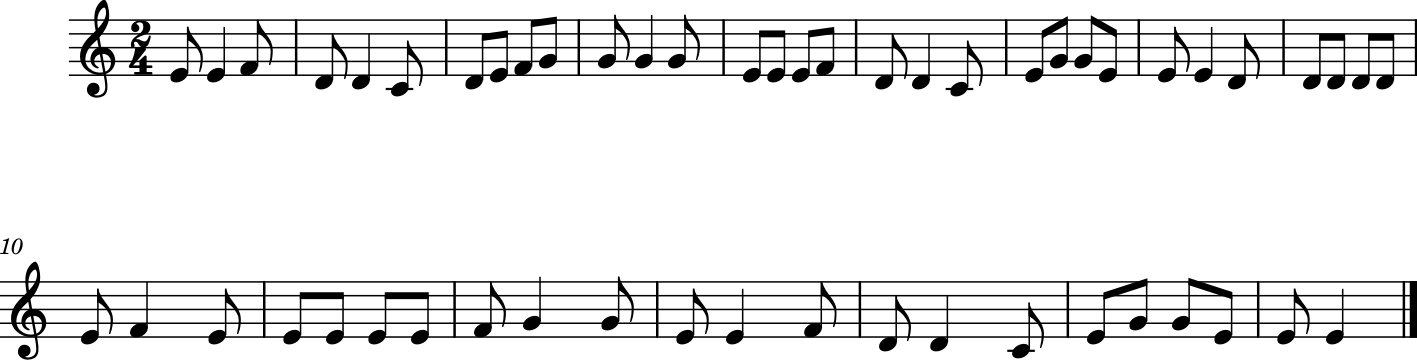

In [7]:
us = music21.environment.UserSettings()
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
m.show()

## 코드 사전 정의 

In [8]:
from keras_preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts([seq])
encoded = t.texts_to_sequences([seq])[0]

print(encoded)
print(t.word_index)

[2, 1, 5, 4, 3, 6, 7, 3, 1, 4, 2, 2, 8, 2, 1, 1, 1, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5, 3, 3, 3, 3, 3, 1, 9, 1, 1, 1, 1, 1, 4, 8, 2, 1, 5, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5]
{'e8': 1, 'g8': 2, 'd8': 3, 'f8': 4, 'e4': 5, 'd4': 6, 'c8': 7, 'g4': 8, 'f4': 9}


In [9]:
code2idx = {'c4': 0, 'd4': 1, 'e4': 2, 'f4': 3, 'g4': 4, 'a4': 5, 'b4': 6,
            'c8': 7, 'd8': 8, 'e8': 9, 'f8': 10, 'g8': 11, 'a8': 12, 'b8': 13}

idx2code = {0: 'c4', 1: 'd4', 2: 'e4', 3: 'f4', 4: 'g4', 5: 'a4', 6: 'b4',
            7: 'c8', 8: 'd8', 9: 'e8', 10: 'f8', 11: 'g8', 12: 'a8', 13: 'b8'}

# 데이터 셋 생성 

In [10]:
code2idx['g8']

11

In [11]:
print([code2idx[item] for item in seq])

[11, 9, 2, 10, 8, 1, 7, 8, 9, 10, 11, 11, 4, 11, 9, 9, 9, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2, 8, 8, 8, 8, 8, 9, 3, 9, 9, 9, 9, 9, 10, 4, 11, 9, 2, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2]


In [12]:
# seq를 학습시킬 데이터 셋으로 반환하는 함수
# seq = 음계가 담긴 list / window_size:독립변수의 갯수

def seq2dataset(seq, window_size):
    dataset = []
    
    for i in range(len(seq) - window_size):
        subset = seq[i : (i + window_size + 1)]
        encoded = [code2idx[item] for item in subset]
        dataset.append(encoded)
    return np.array(dataset)

In [13]:
print(seq[0:10])
print(seq2dataset(seq = seq[0:10], window_size = 4))

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8']
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]]


**생성**

In [14]:
n_steps = 4 # 4개씩 학습(독립변수 갯수)
n_inputs = 1
dataset = seq2dataset(seq = seq, window_size= n_steps)

print(dataset[ :2])
print(dataset.shape)

[[11  9  2 10  8]
 [ 9  2 10  8  1]]
(50, 5)


**독립변수(x) / 종속변수(y)로 분리**

In [15]:
x_train = dataset[ : , :-1]
y_train = dataset[ : , -1]

print(dataset[0])
print(x_train[0], y_train[0])
print(x_train.shape, y_train.shape)

[11  9  2 10  8]
[11  9  2 10] 8
(50, 4) (50,)


In [16]:
# 정규화시킬 때 나눌 값: code2idx의 제일 큰 value값
max_idx_value = max(code2idx.values())
max_idx_value

13

**독립변수 정규화**

In [17]:
print('정규화 전 x_train[ :2]', x_train[ :2], sep = '\n')

정규화 전 x_train[ :2]
[[11  9  2 10]
 [ 9  2 10  8]]


In [19]:
x_train = x_train / float(max_idx_value)
print('정규화 후 x_train[ :2]', x_train[ :2], sep = '\n')

정규화 후 x_train[ :2]
[[0.06508876 0.05325444 0.01183432 0.0591716 ]
 [0.05325444 0.01183432 0.0591716  0.04733728]]


**독립변수(입력값)의 shape변환(샘플 수, nsteps -> 샘플 수, nsteps1)**

In [20]:
x_train.shape

(50, 4)

In [21]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_train.shape

(50, 4, 1)

**종속변수(라벨값)의 원핫인코딩**

In [22]:
y_train

array([ 8,  1,  7,  8,  9, 10, 11, 11,  4, 11,  9,  9,  9, 10,  8,  1,  7,
        9, 11, 11,  9,  9,  2,  8,  8,  8,  8,  8,  9,  3,  9,  9,  9,  9,
        9, 10,  4, 11,  9,  2, 10,  8,  1,  7,  9, 11, 11,  9,  9,  2])

In [23]:
y_train = utils.to_categorical(y_train)
y_train

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [24]:
one_hot_vec_size = y_train.shape[1]
one_hot_vec_size

12

# 모델 구성하기

In [25]:
model = Sequential()

model.add(LSTM(units = 128,
               kernel_initializer = 'glorot_normal',
               bias_initializer = 'zero',
               batch_input_shape = (1, n_steps, n_inputs),
               stateful = True)) 

model.add(Dense(units = one_hot_vec_size,
                kernel_initializer = 'glorot_normal',
                bias_initializer = 'zero',
                activation = 'softmax'))

# 모델 학습과정 설정하기

In [26]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# 모델 학습시키기 

## loss, accuracy 이력 클래스 정의 

In [27]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.accuracy = []
        
    def on_epoch_end(self, batch, logs = {}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        if self.epoch % 100 == 0:
            print("epoch: {0} - loss: {1:8.6f}, accuracy: {2:8.6f}").\
            format(self.epoch, logs.get('loss'), logs.get('accuracy'))
        self.epoch += 1

## 학습 

In [36]:
num_epochs = 1500
history = LossHistory()  # 손실 이력 객체 생성

for epoch_idx in range(num_epochs + 1):
    model.fit(
        x=x_train,
        y=y_train,
        epochs=1,
        batch_size=1,
        verbose=0,
        shuffle=False,
        callbacks=[history]
    )
    if history.losses[-1] < 1e-5:
        print('epoch: {0} - loss: {1:8.6f}'.\
              format(epoch_idx, history.losses[-1]))
        model.reset_states()    
        break;
    model.reset_states()

epoch: {0} - loss: {1:8.6f}, accuracy: {2:8.6f}


AttributeError: 'NoneType' object has no attribute 'format'

In [31]:
print("{ : .5f}".format(1e-5))

KeyError: ' '

# 학습과정 살펴보기

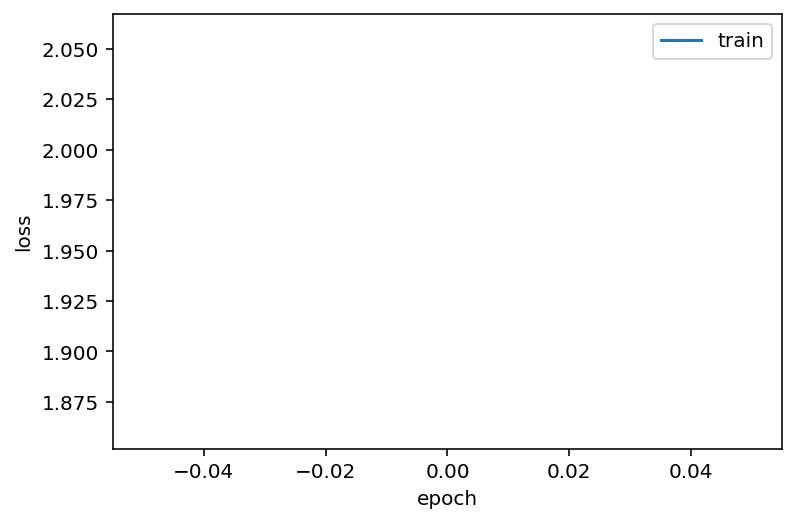

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper right')
plt.show()

# 모델 평가하기

In [40]:
model.evaluate(x_train, y_train, batch_size = 1)
model.reset_states()

50/50 [==============================] - 0s 3ms/step - loss: 1.8920 - accuracy: 0.3400


# 모델 사용하기 

## 바로 다음 한 스텝 예측하기

In [41]:
x_train[0]
temp = x_train[0].reshape(1, 4, 1)
temp

array([[[0.84615385],
        [0.69230769],
        [0.15384615],
        [0.76923077]]])

In [42]:
idx = np.argmax(model.predict(temp))
idx

9

In [43]:
idx2code[idx]

'e8'

## 곡 전체 예측

In [49]:
pred_count = 50 # 최대 예측 수 
seq_in = ['g8', 'c8', 'f4', 'e8']
seq_out = seq_in
seq_in = [code2idx[note] / float(max_idx_value) for note in seq_in] # 코드 ->인덱스값

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, n_steps, n_inputs)) # 샘플 수, 타임스텝 수, 속성 수 
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)
    
model.reset_states()

print("full song prediction: ")

for note in seq_out:
    print(note, end = ' ')

full song prediction: 
g8 c8 f4 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 e8 

In [50]:
print(seq_out)

['g8', 'c8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


In [33]:
# 나비야 초반 : 'g8', 'e8', 'e4', 'f8'
note_seq = ''

for note in seq_out:
    note_seq += note + " "

conv_midi = music21.converter.subConverters.ConverterMidi()
m = music21.converter.parse("2/4 " + note_seq, format='tinyNotation')

m.show("midi")

NameError: name 'seq_out' is not defined